In [1]:
# habilitate src folder to be imported from this notebook
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0])

if module_path not in sys.path:
    sys.path.append(module_path)

___

In [2]:
import tensorflow as tf
import numpy as np
from pathlib import Path

from src.loaders.dataset import DataGenerator
from src.models import (
    DenseAutoencoder,
    CNNAutoencoder
    )
from src.callbacks import CSVTimeHistory

In [3]:
# class CNNAutoencoder(tf.keras.models.Model):

#   def __init__(self,latent_dim,):
#     super(CNNAutoencoder, self).__init__()
#     self.latent_dim = latent_dim   
    
#     # encoder
#     self.encoder = tf.keras.Sequential([
#       tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding="same", activation="relu"),
#       tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same", activation="relu"),
#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(latent_dim, activation="relu")
#     ])

#     # decoder
#     self.decoder = tf.keras.Sequential([
#       tf.keras.layers.Dense(8 * 8 * latent_dim , activation='relu'),
#       tf.keras.layers.Reshape((8, 8, latent_dim)), # output (8,8,latent_dim)
#       tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(2,2), strides=2, activation="relu"), # output (16,16,16)
#       tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(2,2), strides=2, activation="relu"),  # output (32,32,8)
#       tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=2, activation="relu")   # output (64,64,1) 
#     ])

#   def call(self, x):

#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

In [8]:
# Params
BATCH_SIZE=16
EPOCHS=50
LATENT_DIM=100

# training params
PATIENTE_EARLY_STOPPING=20
PATIENTE_EARLY_LR=15

# Data
list_npy = list(Path("../data/fcgr/").rglob("*.npy"))
n_train=round(len(list_npy)*0.8)
preprocessing = lambda x: x / x.max()

In [9]:
train_generator = DataGenerator(
    list_paths=list_npy[:n_train],
    batch_size=BATCH_SIZE,
    shuffle=True,
    preprocessing=preprocessing
)

val_generator = DataGenerator(
    list_paths=list_npy[n_train:],
    batch_size=BATCH_SIZE,
    shuffle=False,
    preprocessing=preprocessing
)

In [10]:
# - Callbacks
# checkpoint: save best weights
Path("../data/train/checkpoints").mkdir(exist_ok=True, parents=True)
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='../data/train/checkpoints/weights-{epoch:02d}-{val_loss:.3f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# reduce learning rate
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=PATIENTE_EARLY_LR,
    verbose=1,
    min_lr=0.00001
)

# stop training if
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.001,
    patience=PATIENTE_EARLY_STOPPING,
    verbose=1
)

# save history of training
Path("../data/train").mkdir(exist_ok=True, parents=True)
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename='../data/train/training_log.csv',
    separator=',',
    append=False
)

cb_csvtime = CSVTimeHistory(
    filename='../data/train/time_log.csv',
    separator=',',
    append=False
)

In [12]:
# training
autoencoder=CNNAutoencoder(LATENT_DIM)
autoencoder.compile(optimizer='adam', loss="binary_crossentropy")#tf.keras.losses.MeanSquaredError())
autoencoder.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS,
    callbacks=[
        #cb_checkpoint,
        cb_reducelr,
        cb_earlystop,
        cb_csvlogger,
        cb_csvtime
        ]
)

Epoch 1/50
1872/1872 [==============================] - 10s 5ms/step - loss: 0.1298 - val_loss: 0.1422 - lr: 0.0010
Epoch 2/50
1872/1872 [==============================] - 10s 5ms/step - loss: 0.1258 - val_loss: 0.1427 - lr: 0.0010
Epoch 3/50
1872/1872 [==============================] - 10s 5ms/step - loss: 0.1251 - val_loss: 0.1422 - lr: 0.0010
Epoch 4/50
1872/1872 [==============================] - 9s 5ms/step - loss: 0.1239 - val_loss: 0.1404 - lr: 0.0010
Epoch 5/50
1872/1872 [==============================] - 10s 5ms/step - loss: 0.1231 - val_loss: 0.1399 - lr: 0.0010
Epoch 6/50
1872/1872 [==============================] - 9s 5ms/step - loss: 0.1222 - val_loss: 0.1393 - lr: 0.0010
Epoch 7/50
1872/1872 [==============================] - 10s 5ms/step - loss: 0.1218 - val_loss: 0.1391 - lr: 0.0010
Epoch 8/50
1872/1872 [==============================] - 9s 5ms/step - loss: 0.1216 - val_loss: 0.1390 - lr: 0.0010
Epoch 9/50
1872/1872 [==============================] - 9s 5ms/step - loss:

In [13]:
autoencoder.summary()

Model: "cnn_autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 100)               1657316   
                                                                 
 sequential_5 (Sequential)   (None, 64, 64, 1)         653369    
                                                                 
Total params: 2,310,685
Trainable params: 2,310,685
Non-trainable params: 0
_________________________________________________________________


___
## Visualize real vs generated FCGR

In [14]:
inference_data = DataGenerator(
    list_paths=list_npy[:100],
    batch_size=10,
    shuffle=False,
    preprocessing=preprocessing,
    inference_mode=True
)

iter_inf_data = iter(inference_data)

In [26]:
# next batch
data = next(iter_inf_data)
data.shape

# predict
encoded_imgs = autoencoder.encoder(data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

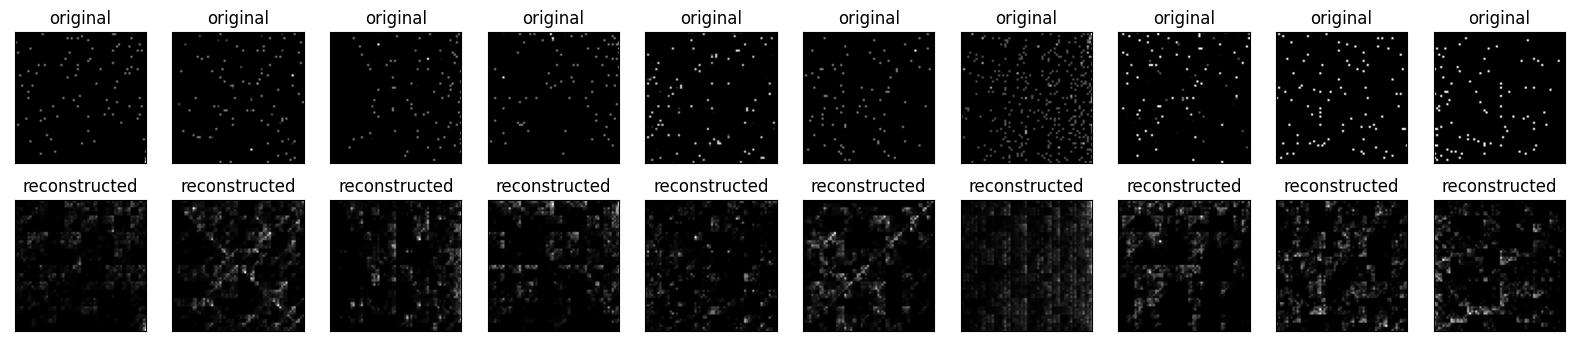

In [27]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(data[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i,:,:,0])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [13]:
decoded_imgs.shape

(10, 64, 64, 1)

In [25]:
encoded_imgs

array([[7.0923269e-01, 2.5613198e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 6.4772201e-01, 0.0000000e+00, 2.1423757e-01,
        2.3115859e+00, 7.9544675e-01, 9.1433871e-01, 5.1425129e-01,
        0.0000000e+00, 5.9580970e-01, 4.9073726e-01, 1.5192488e-01,
        6.2899905e-01, 4.7983053e-01, 7.4115610e-01, 7.3244590e-01,
        6.8626940e-01, 1.8795477e-01, 8.4906971e-01, 1.4630325e-01,
        0.0000000e+00, 6.9230205e-01, 3.5421392e-01, 0.0000000e+00,
        7.7631617e-01, 4.0856883e-01, 8.4114671e-03, 0.0000000e+00,
        5.1303619e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.1368989e-01, 0.0000000e+00, 0.0000000e+00, 8.8568771e-01,
        0.0000000e+00, 4.6565366e-01, 0.0000000e+00, 0.0000000e+00,
        9.3524510e-01, 5.9605062e-01, 0.0000000e+00, 9.3931055e-01,
        0.0000000e+00, 6.5403408e-01, 0.0000000e+00, 0.0000000e+00,
        8.9221036e-01, 1.3396021e+00, 2.4161965e-01, 1.0004911e+00,
        1.0046185e+00, 0.0000000e+00, 0.0000000e

___
# Save embeddings for FAISS

In [29]:
all_data = DataGenerator(
    list_paths=list_npy,
    batch_size=10,
    shuffle=False,
    preprocessing=preprocessing,
    inference_mode=True
)

In [30]:
embeddings = []

for data in iter(all_data):
    encoded_imgs = autoencoder.encoder(data).numpy()
    embeddings.append(encoded_imgs)

In [31]:
all_emb = np.concatenate(embeddings, axis=0)
all_emb.shape

3743

In [37]:
import json

assert len(all_emb) == len(list_npy), "embeddings and ids does not match"

# save embeddings
path_emb = Path("../data/embeddings")
path_emb.mkdir(exist_ok=True, parents=True)
np.save(file=path_emb.joinpath("embeddings.npy"), arr=all_emb)
with open(path_emb.joinpath("id_embeddings.json"), "w") as fp:
    json.dump({j: p.stem for j,p in enumerate(list_npy)}, fp, indent=4)